In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %% load packages
import locale
import sys
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import optuna
import requests
import torch
import random
from sqlalchemy import create_engine,inspect
from pathlib import Path
import urllib.parse
import pyarrow
from calendar import day_abbr
import calendar
from typing import Tuple, Union, Dict, List
from concurrent.futures import ThreadPoolExecutor, as_completed
from pygam import LinearGAM
from datetime import datetime
import pyarrow


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25')

import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\amaguaya\OneDrive - Kienzle Automotive GmbH\Desktop\DLiE\repo\DLiE_forecast_13_06_25\srs\notebooks


In [4]:
from srs.utils.tutor_utils import prepare_dataset_tensor, forecasting_study,\
  plot_daily_profile,plot_hour_comparison, build_multiwindow_experts, tune_ewa_eta, \
  ewa_aggregate_forecasts, compute_error_table, tune_expert_window, \
  run_expert_window_test, build_regression_matrix, SimpleMLP, train_mlp, \
  prepare_train_test_tensors, build_mlp_rolling_forecasts, tune_mlp_hyperparameters, \
  DST_trafo, prepare_dataset_tensor_modified

from srs.utils.our_utils import run_forecast_step, run_forecast_step_modified, prepare_data_forTraining, run_forecast_step_modified_JustTraining, get_holidays_dummy
from srs.collect_data.setup import setup_seed, get_device
from srs.collect_data.entsoe_data import create_entsoe_engine, get_tables, get_spec, \
  get_market_divisions,get_map_codes,get_map_codes_starting_with, get_resolution_codes, \
    prepare_generation, prepare_load,prepare_price, prepare_unavailability, \
    prepare_filling_rate_hydro, prepare_physical_flow, prepare_installed_capacity
from srs.collect_data.datastream_data import create_datastream_engine, get_tables, \
  prepare_datastream
from srs.collect_data.dwd_mosmix_data import fetch_region_weather, prepare_weather
from srs.collect_data.merge_data import merge_datasets, build_training_dataset

from srs.models.light_gbm import forecast_lgbm_whole_sample_optuna_selectBestOptions


### models_24h fitting for all no1-no5 regions separately.

In [5]:
'''
  eval/test periods
  2023 - 365 days
  2024 - 366 days
'''


'\n  eval/test periods\n  2023 - 365 days\n  2024 - 366 days\n'

## EXPERIMENT USING DEFAULT HYPERPARAMETERS VALUES 

## set 1 - all variables

In [6]:
# all_vars_names

In [7]:
'''

'deltaPrice',


'deltaPrice_lag_1',
'deltaPrice_lag_2',
'deltaPrice_lag_7',

'Load_DA_lag_0',
'WindOn_DA_lag_0',

'WD_1',
'WD_6',
'WD_7',

'Coal_lag_2',
'NGas_lag_2',
'Oil_lag_2',
'EUA_lag_2',

'pct_chg_Load_DA',
'lag168_Load_DA',
'volatility_24h_lg1',
'volatility_pct_24h_lg1',
'lag1_price_2nd_diff',

'sin_hour',
'cos_hour',
'sin_week',
'cos_week',
'sin_year',
'cos_year',

'Temp_lag_24',
'Solar_lag_24',
'WindS_lag_24',
'WindDir_lag_24',
'Press_lag_24',
'Humid_lag_24'

'''

"\n\n'deltaPrice',\n\n\n'deltaPrice_lag_1',\n'deltaPrice_lag_2',\n'deltaPrice_lag_7',\n\n'Load_DA_lag_0',\n'WindOn_DA_lag_0',\n\n'WD_1',\n'WD_6',\n'WD_7',\n\n'Coal_lag_2',\n'NGas_lag_2',\n'Oil_lag_2',\n'EUA_lag_2',\n\n'pct_chg_Load_DA',\n'lag168_Load_DA',\n'volatility_24h_lg1',\n'volatility_pct_24h_lg1',\n'lag1_price_2nd_diff',\n\n'sin_hour',\n'cos_hour',\n'sin_week',\n'cos_week',\n'sin_year',\n'cos_year',\n\n'Temp_lag_24',\n'Solar_lag_24',\n'WindS_lag_24',\n'WindDir_lag_24',\n'Press_lag_24',\n'Humid_lag_24'\n\n"

## set 2 - reduce vars

In [8]:
'''

'deltaPrice',


'deltaPrice_lag_1',
'deltaPrice_lag_2',
'deltaPrice_lag_7',

'Load_DA_lag_0',
'WindOn_DA_lag_0',

'Coal_lag_2',
'NGas_lag_2',
'Oil_lag_2',
'EUA_lag_2',

'pct_chg_Load_DA',
'lag168_Load_DA',   
'volatility_24h_lg1', ---- lag 1 day and teh estimate volatiliyty of last 24 hours
'volatility_pct_24h_lg1', ----- lag 1 day volatiliy of pct chamge

'sin_hour',
'cos_hour',
'sin_week',
'cos_week',
'sin_year',
'cos_year',

'Temp_lag_24',
'Solar_lag_24',
'WindS_lag_24',
'WindDir_lag_24',
'Press_lag_24',
'Humid_lag_24'

'''

"\n\n'deltaPrice',\n\n\n'deltaPrice_lag_1',\n'deltaPrice_lag_2',\n'deltaPrice_lag_7',\n\n'Load_DA_lag_0',\n'WindOn_DA_lag_0',\n\n'Coal_lag_2',\n'NGas_lag_2',\n'Oil_lag_2',\n'EUA_lag_2',\n\n'pct_chg_Load_DA',\n'lag168_Load_DA',   \n'volatility_24h_lg1', ---- lag 1 day and teh estimate volatiliyty of last 24 hours\n'volatility_pct_24h_lg1', ----- lag 1 day volatiliy of pct chamge\n\n'sin_hour',\n'cos_hour',\n'sin_week',\n'cos_week',\n'sin_year',\n'cos_year',\n\n'Temp_lag_24',\n'Solar_lag_24',\n'WindS_lag_24',\n'WindDir_lag_24',\n'Press_lag_24',\n'Humid_lag_24'\n\n"

In [312]:
# set the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **************************************
# define dates for training and evaluation 
# **************************************
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE = '2023-01-01'
FINAL_DATE_EXPERIMENTS = '2024-12-31'
n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment
StoreDataForR = True

repo_root = Path.cwd().parents[1]
mapcodes =  ["NO1","NO2","NO3","NO4","NO5"] #  ["NO1"]
maps_dict = {}

# holidays dataset
holidays_df = pd.read_csv(repo_root / "data" / f"holidays_2000_2030.csv", parse_dates=["Date"])

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df = pd.read_csv(csv_path, parse_dates=["time_utc"])   
    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz="CET",
        seed=42,
        test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
        dtype=torch.float64,
    )

    # fix potential problems with dates after change time zone..
    train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
    id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
    train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

    print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
    maps_dict[code] = {
        "df": df,
        "data_t": data_t,
        "train_t": train_t,
        "train_dates": train_dates,
        "price_t": price_t
    }
maps_dict.keys()

preds_by_zone   = {}
true_values_by_zone   = {}
rmse_by_zone  = {}
rmse_in_training_by_zone = {}

##########################################################################################################################################################################
# Define models and select variables to apply smooth spline, and for the rest it will use a line spline
##########################################################################################################################################################################
LS_MODELS_TRAIN = ['gam_24hAhead'] # ['gam_24hAhead', 'lgbm_24hAhead_defaultHyper', 'lgbm_24hAhead_withOptune', 'lgbm_24hAhead_LongShortTermWithOptune'] 
LS_VAR_APPLY_SMOOTH_SPLINE = [ "Load_DA_lag_0", "WindOn_DA_lag_0", 'pct_chg_Load_DA', 'volatility_24h_lg1',
                              'Temp_lag_24', 'Solar_lag_24', 'WindS_lag_24', 'WindDir_lag_24', 'Press_lag_24,'
                              'Humid_lag_24']
LS_VAR_APPLY_CYCLECUBIC_SPLINE = [ "sin_hour", "cos_hour", 'sin_week', 'cos_week',
                              'sin_year', 'cos_year'] 
LS_VAR_APPLY_INTERACTION = [ ("Temp_lag_24", "WindS_lag_24"), ('Load_DA_lag_0', 'volatility_24h_lg1')] 
MODEL_USING_FIRST_DIFF = True
NR_TRIALS_GBM = 6
DAYS_SHORT_TERM_MODEL = 7

for z in mapcodes:
    print(f"\n--- {z} ---")
    price_S      = maps_dict[z]["price_t"]
    data_array   = maps_dict[z]["data_t"]
    full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
    feature_names= maps_dict[z]["df"].columns[1:]
    full_date_series = pd.DatetimeIndex(sorted(full_dates))

    # evaluation days (all of 2024)
    train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    eval_start_idx = id_init_eval
    eval_end_idx  = id_end_eval
    N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
    full_dates = pd.to_datetime(full_dates)

    

    # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
    WD              = [1,6,7]     
    PRICE_S_LAGS    = [1,2,7]
    DA_LAG          = [0]
    S               = 24
    FUEL_LAGS       = [2]
    WEATHER_LAG     = [1]
    
    # original price and first lag all data
    full_price_original = data_array[:,:, 0].detach().clone().to(device)
    # Flatten to 1D time series (days × hours)
    flat_price = full_price_original.reshape(-1)
    # Lag with NaN at the beginning
    first_lag_flat = torch.cat([
        torch.full((S,), float('nan'), device=flat_price.device),
        flat_price[:-S]
    ])


    # Reshape back to (days, hours)
    full_price_first_lag = first_lag_flat.reshape(full_price_original.shape)

    # Step 4: Extract evaluation window
    first_lag_price_eval = full_price_first_lag[eval_start_idx : eval_end_idx + 1, :] 
    first_lag_price_eval = first_lag_price_eval.reshape(-1)

    # weather data
    ds_weather = pd.read_csv(repo_root / "data" / f"all_weather_data.csv", parse_dates=["time_utc"]).iloc[:,1:]
    ds_weather_zone = ds_weather[ (ds_weather.time_utc.dt.year >= pd.to_datetime(INIT_DATE_EXPERIMENTS).year ) &
                                 (ds_weather.time_utc.dt.year <= pd.to_datetime(FINAL_DATE_EXPERIMENTS).year ) &
                                 (ds_weather.MapCode == code) ].copy()
    ds_weather_zone.drop(columns=["MapCode", "time_utc"], inplace=True)

    # prepare data
    all_vars_names, Xy_t = prepare_data_forTraining(
            ds_weather_zone,
            data_array, 
            full_dates, 
            WD, 
            PRICE_S_LAGS, DA_LAG, feature_names, 
            FUEL_LAGS,
            WEATHER_LAG,
            full_dates, 
            holidays_df, 
            model_first_diff_price = MODEL_USING_FIRST_DIFF,
            dayahead=1, daybefore= 0.5)
    
    print(f"the models will use these features: {all_vars_names[1:]},...length: {len(all_vars_names)}")
    
    if StoreDataForR:  
        # Flatten tensor to 2D
        # Add full_price_original as an additional feature (last dimension)
        full_price_original_exp = full_price_original.unsqueeze(-1)  # Shape: (days, hours, 1)
        Xy_t_tmp = torch.cat([Xy_t,full_price_original_exp], dim=-1)  
        Xy_flat = Xy_t_tmp.reshape(-1, Xy_t_tmp.shape[2]).cpu().numpy()
        
        tmp_vars = (all_vars_names+['Price_orig'])
        # DataFrame with feature names
        ds_ = pd.DataFrame(Xy_flat, columns= tmp_vars)

        # Save as Parquet
        ds_.to_parquet(Path.cwd().parents[1] / "data_for_R" / f"Xy_t_{z}.parquet", index=False)

days for test data ..731
days for test data ..731
days for test data ..731
days for test data ..731
days for test data ..731

--- NO1 ---
the models will use these features: ['deltaPrice_lag_1', 'deltaPrice_lag_2', 'deltaPrice_lag_7', 'Load_DA_lag_0', 'WindOn_DA_lag_0', 'WD_1', 'WD_6', 'WD_7', 'Coal_lag_2', 'NGas_lag_2', 'Oil_lag_2', 'EUA_lag_2', 'Temp_lag_1', 'Solar_lag_1', 'WindS_lag_1', 'WindDir_lag_1', 'Press_lag_1', 'Humid_lag_1', 'pct_chg_Load_DA', 'lag168_Load_DA', 'sin_hour', 'cos_hour', 'sin_week', 'cos_week', 'sin_year', 'cos_year', 'volatility_24h_lg1', 'volatility_pct_24h_lg1'],...length: 29

--- NO2 ---
the models will use these features: ['deltaPrice_lag_1', 'deltaPrice_lag_2', 'deltaPrice_lag_7', 'Load_DA_lag_0', 'WindOn_DA_lag_0', 'WD_1', 'WD_6', 'WD_7', 'Coal_lag_2', 'NGas_lag_2', 'Oil_lag_2', 'EUA_lag_2', 'Temp_lag_1', 'Solar_lag_1', 'WindS_lag_1', 'WindDir_lag_1', 'Press_lag_1', 'Humid_lag_1', 'pct_chg_Load_DA', 'lag168_Load_DA', 'sin_hour', 'cos_hour', 'sin_week', '

In [ ]:
[48, 49, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 38441]

SyntaxError: invalid syntax (2063010231.py, line 1)

In [283]:
Xy_t_tmp

tensor([[[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan, 49.2500],
         [    nan,     nan,     nan,  ...,     nan,     nan, 49.1700],
         ...,
         [    nan,     nan,     nan,  ...,     nan,     nan, 49.1000],
         [    nan,     nan,     nan,  ...,     nan,     nan, 49.4200],
         [    nan,     nan,     nan,  ...,     nan,     nan, 49.1200]],

        [[    nan,     nan,     nan,  ...,     nan,     nan, 49.1600],
         [-1.1100,     nan,     nan,  ...,     nan,     nan, 48.1400],
         [-1.0300,     nan,     nan,  ...,     nan,     nan, 48.1400],
         ...,
         [ 3.6100,     nan,     nan,  ...,     nan,     nan, 52.7100],
         [ 2.6700,     nan,     nan,  ...,     nan,     nan, 52.0900],
         [ 1.6400,     nan,     nan,  ...,     nan,     nan, 50.7600]],

        [[ 0.8700,     nan,     nan,  ...,     nan,     nan, 50.0300],
         [ 0.7500, -1.1100,     nan,  ...,  0

In [316]:
# set the GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **************************************
# define dates for training and evaluation 
# **************************************
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE = '2023-01-01'
FINAL_DATE_EXPERIMENTS = '2024-12-31'
n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment
StoreDataForR = False

repo_root = Path.cwd().parents[1]
mapcodes = ["NO1","NO2","NO3","NO4","NO5"] #  ["NO1"]
maps_dict = {}

# holidays dataset
holidays_df = pd.read_csv(repo_root / "data" / f"holidays_2000_2030.csv", parse_dates=["Date"])

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df = pd.read_csv(csv_path, parse_dates=["time_utc"])   
    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz="CET",
        seed=42,
        test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
        dtype=torch.float64,
    )

    # fix potential problems with dates after change time zone..
    train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
    id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
    train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

    print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
    maps_dict[code] = {
        "df": df,
        "data_t": data_t,
        "train_t": train_t,
        "train_dates": train_dates,
        "price_t": price_t
    }
maps_dict.keys()

preds_by_zone   = {}
true_values_by_zone   = {}
rmse_by_zone  = {}
rmse_in_training_by_zone = {}

##########################################################################################################################################################################
# Define models and select variables to apply smooth spline, and for the rest it will use a line spline
##########################################################################################################################################################################
LS_MODELS_TRAIN = ['lgbm_24hAhead_defaultHyper'] # ['gam_24hAhead', 'lgbm_24hAhead_defaultHyper', 'lgbm_24hAhead_withOptune', 'lgbm_24hAhead_LongShortTermWithOptune'] 
LS_VAR_APPLY_SMOOTH_SPLINE = [ "Load_DA_lag_0", "WindOn_DA_lag_0", 'pct_chg_Load_DA', 'volatility_24h_lg1',
                              'Temp_lag_24', 'Solar_lag_24', 'WindS_lag_24', 'WindDir_lag_24', 'Press_lag_24,'
                              'Humid_lag_24']
LS_VAR_APPLY_CYCLECUBIC_SPLINE = [ "sin_hour", "cos_hour", 'sin_week', 'cos_week',
                              'sin_year', 'cos_year'] 
LS_VAR_APPLY_INTERACTION = [ ("Temp_lag_24", "WindS_lag_24"), ('Load_DA_lag_0', 'volatility_24h_lg1')] 
MODEL_USING_FIRST_DIFF = True
NR_TRIALS_GBM = 6
DAYS_SHORT_TERM_MODEL = 7

for z in mapcodes:
    print(f"\n--- {z} ---")
    price_S      = maps_dict[z]["price_t"]
    data_array   = maps_dict[z]["data_t"]
    full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
    feature_names= maps_dict[z]["df"].columns[1:]
    full_date_series = pd.DatetimeIndex(sorted(full_dates))

    # evaluation days (all of 2024)
    train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    eval_start_idx = id_init_eval
    eval_end_idx  = id_end_eval
    N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
    full_dates = pd.to_datetime(full_dates)

    

    # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
    WD              = [1,6,7]     
    PRICE_S_LAGS    = [1,2,7]
    DA_LAG          = [0]
    S               = 24
    FUEL_LAGS       = [2]
    WEATHER_LAG     = [1]
    
    # original price and first lag all data
    full_price_original = data_array[:,:, 0].detach().clone().to(device)
    # Flatten to 1D time series (days × hours)
    flat_price = full_price_original.reshape(-1)
    # Lag with NaN at the beginning
    first_lag_flat = torch.cat([
        torch.full((S,), float('nan'), device=flat_price.device),
        flat_price[:-S]
    ])


    # Reshape back to (days, hours)
    full_price_first_lag = first_lag_flat.reshape(full_price_original.shape)

    # Step 4: Extract evaluation window
    first_lag_price_eval = full_price_first_lag[eval_start_idx : eval_end_idx + 1, :] 
    first_lag_price_eval = first_lag_price_eval.reshape(-1)

    # weather data
    ds_weather = pd.read_csv(repo_root / "data" / f"all_weather_data.csv", parse_dates=["time_utc"]).iloc[:,1:]
    ds_weather_zone = ds_weather[ (ds_weather.time_utc.dt.year >= pd.to_datetime(INIT_DATE_EXPERIMENTS).year ) &
                                 (ds_weather.time_utc.dt.year <= pd.to_datetime(FINAL_DATE_EXPERIMENTS).year ) &
                                 (ds_weather.MapCode == code) ].copy()
    ds_weather_zone.drop(columns=["MapCode", "time_utc"], inplace=True)

    # prepare data
    all_vars_names, Xy_t = prepare_data_forTraining(
            ds_weather_zone,
            data_array, 
            full_dates, 
            WD, 
            PRICE_S_LAGS, DA_LAG, feature_names, 
            FUEL_LAGS,
            WEATHER_LAG,
            full_dates, 
            holidays_df, 
            model_first_diff_price = MODEL_USING_FIRST_DIFF,
            dayahead=1, daybefore= 0.5)
    
    print(f"the models will use these features: {all_vars_names[1:]},...length: {len(all_vars_names)}")
    
    # decide if i wanna store the data
    if StoreDataForR:  
        # Flatten tensor to 2D
        # Add full_price_original as an additional feature (last dimension)
        full_price_original_exp = full_price_original.unsqueeze(-1)  # Shape: (days, hours, 1)
        Xy_t_tmp = torch.cat([Xy_t,full_price_original_exp], dim=-1)  
        Xy_flat = Xy_t_tmp.reshape(-1, Xy_t_tmp.shape[2]).cpu().numpy()
        
        tmp_vars = (all_vars_names+['Price_orig'])
        # DataFrame with feature names
        ds_ = pd.DataFrame(Xy_flat, columns= tmp_vars)

        # Save as Parquet
        ds_.to_parquet(Path.cwd().parents[1] / "data_for_R" / f"Xy_t_{z}.parquet", index=False)
    
    # tensors to collect forecasts for THIS zone
    forecasts_zone = torch.full((N_s, S, len(LS_MODELS_TRAIN)), float("nan"),
                                dtype=torch.float64, device=device)
    rmse_zone = torch.full((N_s, len(LS_MODELS_TRAIN)), float("nan"),
                                dtype=torch.float64, device=device)
    

    # thread pool
    with ThreadPoolExecutor(max(1, os.cpu_count() // 2) + 0 ) as executor:
        futures = [
            executor.submit(
                run_forecast_step_modified_JustTraining,
                full_price_original             = full_price_original,
                full_price_first_lag            = full_price_first_lag,
                n                               = n,
                data_array                      = Xy_t,
                train_start_idx                 = train_start_idx,
                train_end_idx                   = id_init_eval - 1,
                full_dates                      = full_dates,
                feature_names                   = all_vars_names,   # reg_names
                ls_models                       = LS_MODELS_TRAIN, # models to estimate
                apply_smoo_spline_over_varList  = LS_VAR_APPLY_SMOOTH_SPLINE,
                apply_cubic_spline_over_varList = LS_VAR_APPLY_CYCLECUBIC_SPLINE,
                apply_cubic_inter_over_varList  = LS_VAR_APPLY_INTERACTION,
                n_trials_lgbm                   = NR_TRIALS_GBM,
                days_for_st_model               = DAYS_SHORT_TERM_MODEL,
                first_diff                      = MODEL_USING_FIRST_DIFF
            )
            for n in range(N_s)
        ]

        for fut in as_completed(futures):
            try:
                n, ls_rmse_train, ls_res_pred = fut.result()
                for idx, pred_vc in enumerate(ls_res_pred):
                    forecasts_zone[n, :, idx] = pred_vc.detach().clone().to(forecasts_zone.dtype).to(forecasts_zone.device)
                    rmse_zone[n, idx] = ls_rmse_train[idx]
            except Exception as e:
                import traceback
                print(f"Thread crashed: {e}")
                traceback.print_exc()

    true_vals = price_S[eval_start_idx : eval_end_idx + 1].to(device) 
    true_values_by_zone [z] = true_vals.reshape(-1).cpu()
    preds_tuple_ls = []
    rmse_tuple_ls =[]
    rmse_in_train_ls =[]
    for idx_,md_ in enumerate(LS_MODELS_TRAIN):
        forecasted_delta = forecasts_zone[:, :, idx_].reshape(-1)
        print(f"results of model.... {md_}") 
        if MODEL_USING_FIRST_DIFF == False:
            pred_adj = forecasted_delta
            tuple_forc = [(pred_adj, pred_adj)]
            preds_tuple_ls = preds_tuple_ls + tuple_forc
        # compute RMSE, first lag of price + forecast of delta_var - true values
        else:
            last_price = first_lag_price_eval
            pred_adj = forecasted_delta + last_price
            tuple_forc = [(last_price, pred_adj)]
            preds_tuple_ls = preds_tuple_ls + tuple_forc
        diff = pred_adj - true_vals.reshape(-1)
        valid_mask = ~torch.isnan(diff)
        diff = diff[valid_mask]
        rmse = torch.sqrt((diff**2).mean()).item()
        rmse_tuple_ls = rmse_tuple_ls + [(rmse)]
        print(f"Zone {z}, model {md_}, RMSE: {rmse:.4f}")
        # estimate average RMSE of training
        valid_mask_training = ~torch.isnan(rmse_zone[:, idx_])
        avg_rmse_train_md = float(torch.mean(rmse_zone[valid_mask_training, idx_]))
        print(f"Zone {z}, model {md_}, avg RMSE in sample: {avg_rmse_train_md:.4f}")
        rmse_in_train_ls.append(avg_rmse_train_md)


    preds_by_zone[z] = preds_tuple_ls
    rmse_by_zone[z]  = rmse_tuple_ls
    rmse_in_training_by_zone[z]  = rmse_in_train_ls
    

days for test data ..731
days for test data ..731
days for test data ..731
days for test data ..731
days for test data ..731

--- NO1 ---
the models will use these features: ['deltaPrice_lag_1', 'deltaPrice_lag_2', 'deltaPrice_lag_7', 'Load_DA_lag_0', 'WindOn_DA_lag_0', 'WD_1', 'WD_6', 'WD_7', 'Coal_lag_2', 'NGas_lag_2', 'Oil_lag_2', 'EUA_lag_2', 'Temp_lag_1', 'Solar_lag_1', 'WindS_lag_1', 'WindDir_lag_1', 'Press_lag_1', 'Humid_lag_1', 'pct_chg_Load_DA', 'lag168_Load_DA', 'sin_hour', 'cos_hour', 'sin_week', 'cos_week', 'sin_year', 'cos_year', 'volatility_24h_lg1', 'volatility_pct_24h_lg1'],...length: 29
Loop   0: train 2019-01-01 00:00:00 -> 2022-12-31 00:00:00, forecast 2023-01-01 00:00:00
  dat_slice shape: torch.Size([1462, 24, 29])  → flatten count = 35088
Loop   1: train 2019-01-02 00:00:00 -> 2023-01-01 00:00:00, forecast 2023-01-02 00:00:00
  dat_slice shape: torch.Size([1462, 24, 29])  → flatten count = 35088
Loop   2: train 2019-01-03 00:00:00 -> 2023-01-02 00:00:00, forecast 

In [318]:
rmse_by_zone

{'NO1': [20.083023332116678],
 'NO2': [22.081178738182068],
 'NO3': [16.17280121983606],
 'NO4': [12.036351328625752],
 'NO5': [16.35969662140734]}

In [16]:
import json

# Convert tensors to lists
preds_by_zone_serializable = {
    k: [(v[0].cpu().tolist(), v[1].cpu().tolist()) for v in vals]
    for k, vals in preds_by_zone.items()
}

# Save to JSON

with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results_update_diff/set3_features/resultspredictions_w_lgbm_def_set3.json', 'w') as f:
    json.dump(preds_by_zone_serializable, f)

# Save to JSON
with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results_update_diff/set3_features/resultsRMSE_w_lgbm_def_set3.json', 'w') as f:
    json.dump(rmse_by_zone, f)

with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results_update_diff/set3_features/avg_rmse_in_training_w_lgbm_def_set3.json', 'w') as f:
    json.dump(rmse_in_training_by_zone, f)

In [17]:
# import json

# # Convert tensors to lists
# preds_by_zone_serializable = {
#     k: [(v[0].cpu().tolist(), v[1].cpu().tolist()) for v in vals]
#     for k, vals in preds_by_zone.items()
# }

# # Save to JSON
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultspredictions_w_lgbm_def_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultspredictions_w_gam_w_ssp_csp_inter_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultspredictions_w_gam_w_ssp_csp_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set1_features/resultspredictions_w_gam_w_ssp_csp_inter_set1.json', 'w') as f:

# with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set3_features/resultspredictions_w_lgbm_def_set3.json', 'w') as f:
#     json.dump(preds_by_zone_serializable, f)

# # Save to JSON
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultsRMSE_w_lgbm_def_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultsRMSE_w_gam_w_ssp_csp_inter_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set2_features/resultsRMSE_w_gam_w_ssp_csp_set2.json', 'w') as f:
# # with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set1_features/resultsRMSE_w_gam_w_ssp_csp_inte_set1.json', 'w') as f:
# with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set3_features/resultsRMSE_w_lgbm_def_set3.json', 'w') as f:
#     json.dump(rmse_by_zone, f)

# with open('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25/results/set3_features/avg_rmse_in_training_w_lgbm_def_set3.json', 'w') as f:
#     json.dump(rmse_in_training_by_zone, f)

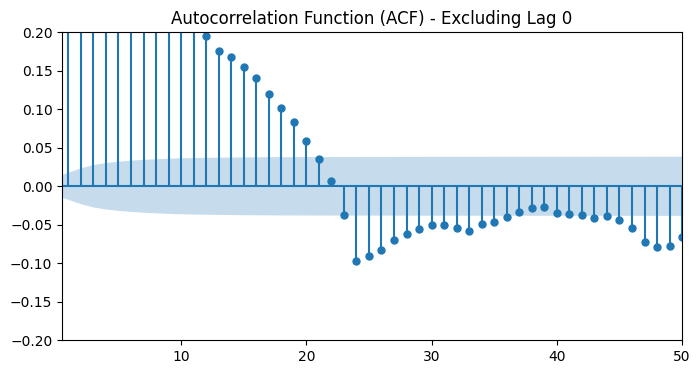

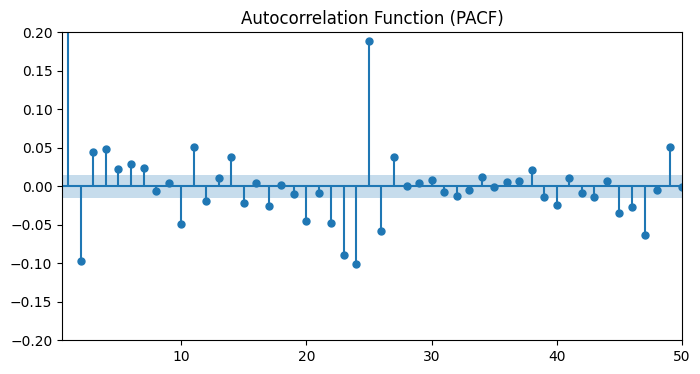

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Example series
series = pd.Series(diff.reshape(-1))  # Replace with your time series array

# --- Plot ACF ---
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(series.dropna(), lags=50, ax = ax)
ax.set_xlim(0.5, 50)  # Start from lag 1, up to lag 50
ax.set_ylim(-0.2, 0.2) 
plt.title("Autocorrelation Function (ACF) - Excluding Lag 0")
plt.show()


# --- Plot PACF ---
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(series.dropna(), lags=50, ax= ax)
plt.title("Autocorrelation Function (PACF)")
ax.set_xlim(0.5, 50)  # Start from lag 1, up to lag 50
ax.set_ylim(-0.2, 0.2) 
plt.show()

In [22]:
# --- Dickey-Fuller Test ---
result = adfuller(series.dropna())

print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
for key, value in result[4].items():
    print(f'Critical Value {key}: {value:.4f}')

# Interpretation
if result[1] < 0.05:
    print("✅ Reject Null Hypothesis: Series is stationary.")
else:
    print("⚠️ Cannot Reject Null Hypothesis: Series is non-stationary.")

ADF Statistic: -19.4607
p-value: 0.0000
Critical Value 1%: -3.4307
Critical Value 5%: -2.8617
Critical Value 10%: -2.5669
✅ Reject Null Hypothesis: Series is stationary.


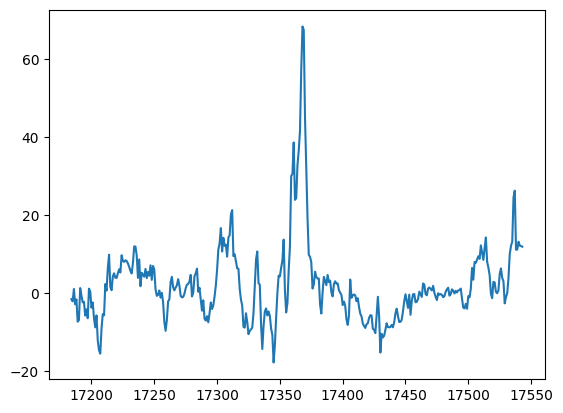

In [23]:
plt.plot(pd.Series(diff)[-(24*15):]) #17200

{'bodies': [<matplotlib.collections.PolyCollection at 0x204880ede50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x20488085b50>,
 'cmins': <matplotlib.collections.LineCollection at 0x204880cf610>,
 'cbars': <matplotlib.collections.LineCollection at 0x20488c95710>}

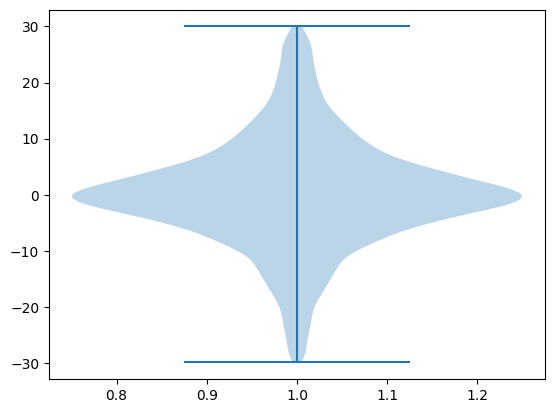

In [25]:
plt.violinplot( pd.Series(diff)[ (pd.Series(diff)<=30) & (pd.Series(diff)>=-30) ]  )

## EXPERIMENT USING OPTUNA, AND BEST MODEL OPTION (CURRENT, BEST PREVIOUS AND COMBINATED)

- This just can be run via typical loop because it is sequential process

In [207]:
# # set the GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # **************************************
# # define dates for training and evaluation 
# # **************************************
# INIT_DATE_EXPERIMENTS = '2019-01-01'
# INIT_TEST_DATE = '2023-01-01'
# FINAL_DATE_EXPERIMENTS = '2024-12-31'
# n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment

# repo_root = Path.cwd().parents[1]
# mapcodes = ["NO1"] # ["NO1","NO2","NO3","NO4","NO5"]
# maps_dict = {}

# for code in mapcodes:
#     csv_path = repo_root / "data" / f"data_{code}.csv"
#     df = pd.read_csv(csv_path, parse_dates=["time_utc"])
#     data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
#         csv_path,
#         tz="CET",
#         seed=42,
#         test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
#         dtype=torch.float64,
#     )

#     # fix potential problems with dates after change time zone..
#     train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
#     id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
#     id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
#     id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
#     data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
#     train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

#     print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
#     maps_dict[code] = {
#         "df": df,
#         "data_t": data_t,
#         "train_t": train_t,
#         "train_dates": train_dates,
#         "price_t": price_t
#     }
# maps_dict.keys()

# lgbm24_by_zone   = {}
# rmse_by_zone  = {}



# for z in mapcodes:
#     print(f"\n--- {z} ---")
#     price_S      = maps_dict[z]["price_t"]
#     data_array   = maps_dict[z]["data_t"]
#     full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
#     feature_names= maps_dict[z]["df"].columns[1:]
#     full_date_series = pd.DatetimeIndex(sorted(full_dates))

#     # evaluation days (all of 2024)
#     train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
#     id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
#     id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
#     eval_start_idx = id_init_eval
#     eval_end_idx  = id_end_eval
#     N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
#     full_dates = pd.to_datetime(full_dates)

    

#     # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
#     WD             = [1,6,7]     
#     PRICE_S_LAGS   = [1,2,7]
#     DA_LAG         = [0]
#     S              = 24
#     #D             = 730

#     # tensors to collect forecasts for THIS zone
#     forecasts_zone = torch.full((N_s, S, 1), float("nan"),
#                                 dtype=torch.float64, device=device)
#     train_end_idx   = id_init_eval - 1
#     ls_models_lgm = []

#     for n in range(N_s):
#         print(f"********************* START NS ... {n} ****************************************************")

#         if n == 0:
#             reduction = 0
#         else:
#             reduction = 60 * ((n - 1) // 100 + 1)
#         # compute the window bounds
#         start_idx = train_start_idx + n + reduction # rolling window (train_start_idx + n)
#         end_idx   = train_end_idx  +  n   # inclusive
        
#         # slice out the training data & dates
#         dat_slice = data_array[start_idx : (end_idx + 2)]
#         days      = pd.Series(full_dates[start_idx : (end_idx + 2) ])

#         # Generate forecasts using expert_ext model and save them
#         result_lgbm_iter                = forecast_lgbm_whole_sample_optuna_selectBestOptions(
#         dat                             = dat_slice,
#         days                            = days,
#         wd                              = WD,
#         price_s_lags                    = PRICE_S_LAGS,
#         da_lag                          = DA_LAG,
#         reg_names                       = feature_names,
#         fuel_lags                       = [2],
#         ls_models_lgm                   = ls_models_lgm, 
#         n_iteration                     = n, 
#         n_trials_lgbm                   = 15
#         )

#         forecasts_zone[n, :, 0] = result_lgbm_iter['forecasts'].detach().clone().to(forecasts_zone.dtype).to(forecasts_zone.device)
#         ls_models_lgm = result_lgbm_iter['ls_models_lgm']

#         # Progress tracker (as percentage)
#         progress = torch.tensor((n + 1) / N_s * 100, dtype=torch.float64)
#         print(f"\r-> {progress.item():.2f}% done", end="")
#         print(f"\n********************* END NS.. {n} ****************************************************")
            
#     #   shape: (N_s, S)
#     true_vals = price_S[eval_start_idx : eval_end_idx + 1].to(device)  
    
#     # compute RMSE
#     diff = forecasts_zone[:, :, 0] - true_vals
#     rmse = torch.sqrt((diff**2).mean()).item()
    
#     print(f"Zone {z} LBGM-24h RMSE: {rmse:.4f}")

#     lgbm24_by_zone[z] = forecasts_zone[:, :, 0].cpu()
#     rmse_by_zone[z]  = rmse

## Debugging of dates with the highest errors

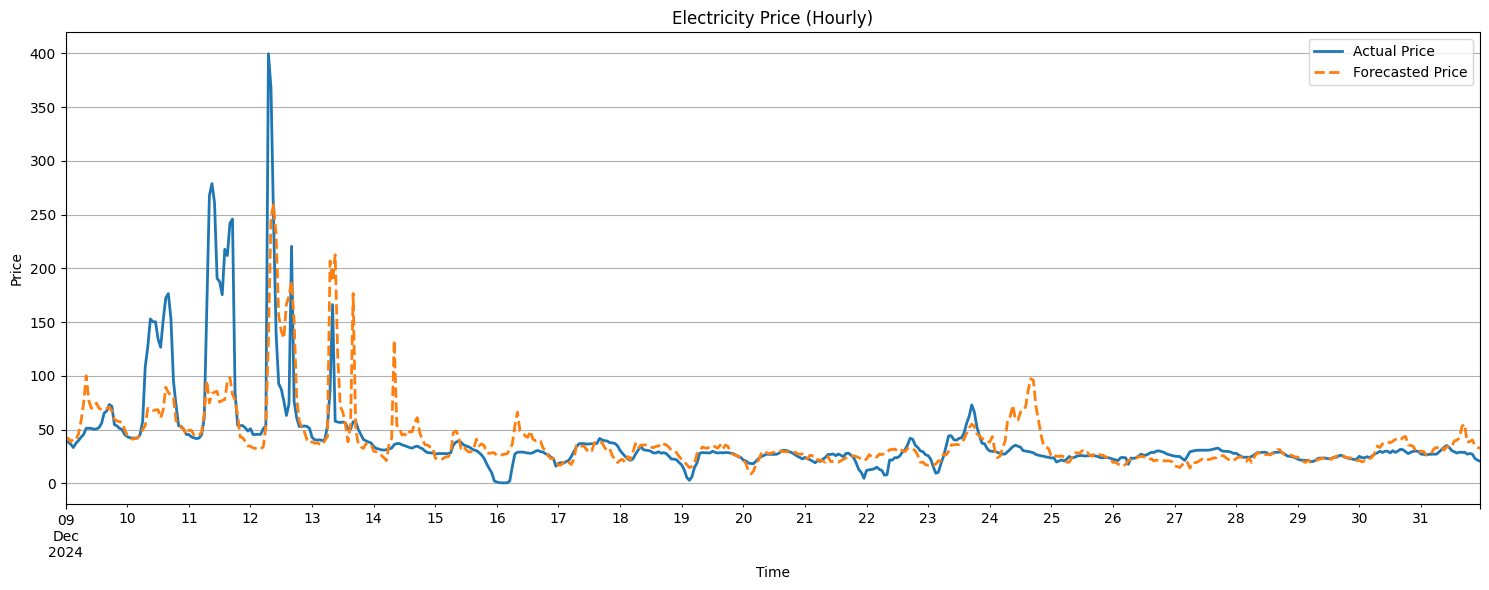

In [26]:
# Step 1: Flatten the time series (days × hours → 1D)
flattened_series = data_t[:, :, 0].reshape(-1).cpu().numpy()

# Step 2: Create a matching hourly datetime index
# There are 24 hours per day, so total points = 2192 days × 24 = 52608
start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')
predicted_series = pd.Series(forecasts_zone.reshape(-1) + first_lag_price_eval, index = datetime_index[-(N_s*24):] )
# Check: both must match in length
assert len(flattened_series) == len(datetime_index)

# Step 3: Create the Series and plot
price_series_flat = pd.Series(flattened_series, index=datetime_index)
price_series_flat = price_series_flat[-(N_s*24):]

plt.figure(figsize=(15, 6))
# Actual price (full series or just the last day)
price_series_flat[-(24*7*3)-(2*24):].plot(label='Actual Price', linewidth=2)
predicted_series[-(24*7*3)-(2*24):].plot(label='Forecasted Price', linewidth=2, linestyle='--')
plt.title("Electricity Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

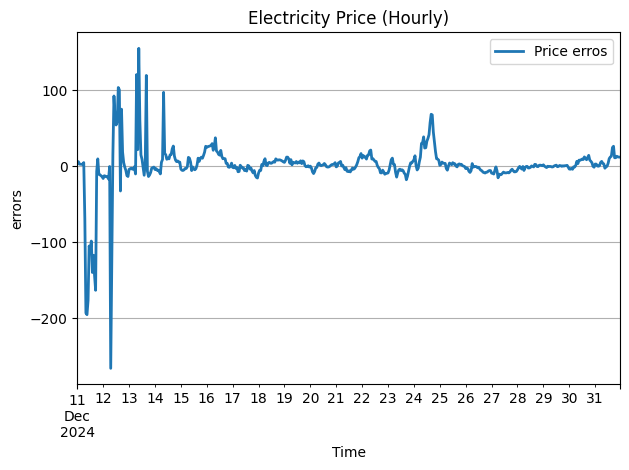

In [27]:
errors_series = pd.Series(diff, index = datetime_index[-(N_s*24):] )

# Actual errors
errors_series[-(24*21):].plot(label='Price erros', linewidth=2)
plt.title("Electricity Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("errors")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [28]:
# get dates with highest error values
# Flatten and compute absolute error
datetime_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')
errors = abs(diff.reshape(-1).cpu().numpy())
time_index = datetime_index[-(N_s * 24):]

# Create DataFrame with datetime, error, and day name
df_errors = pd.DataFrame({
    "DateTime": time_index,
    "AbsError": errors
})
df_errors["Day"] = df_errors["DateTime"].dt.day_name()
# Sort by highest error
df_sorted_errors = df_errors.sort_values("AbsError", ascending=False)

# Display top 10 with day names
print(df_sorted_errors.head(5))

                 DateTime    AbsError       Day
8873  2024-01-05 17:00:00  402.677586    Friday
8872  2024-01-05 16:00:00  343.943052    Friday
17071 2024-12-12 07:00:00  265.682578  Thursday
8897  2024-01-06 17:00:00  227.773854  Saturday
8874  2024-01-05 18:00:00  227.477242    Friday


In [29]:
df_sorted_errors.Day.head(950).value_counts().head(8)

Day
Monday       280
Tuesday      153
Wednesday    141
Thursday     102
Saturday     101
Sunday        90
Friday        83
Name: count, dtype: int64

In [30]:
df_sorted_errors.DateTime.dt.hour.head(2000).value_counts().head(10) # highest errors ocurr at 7 am

DateTime
8     157
7     131
9     128
11    111
10    109
12    109
15    108
18    104
17    102
14     99
Name: count, dtype: int64

In [265]:
# get ids of specific dates
start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index__ = pd.date_range(start=start_datetime, end=end_datetime, freq='H')
target_time = pd.Timestamp("2024-12-12 07:00:00")
index_pos = datetime_index__.get_loc(target_time)
day_idx = index_pos // 24  
day_idx

# get data for these specific dates
tmd_ds = pd.DataFrame(data_array.cpu().numpy().reshape(-1, data_array.shape[2]))
tmd_ds[10] = tmd_ds[0].pct_change()*100
tmd_ds[11] = tmd_ds[1].pct_change()*100
tmd_ds[12] = tmd_ds[2].pct_change()*100
tmd_ds["lag168_0"] = tmd_ds[0].shift(168)  # Price
tmd_ds["lag168_2"] = tmd_ds[2].shift(168)  # Load
tmd_ds["lag24_0"] = tmd_ds[0].shift(24)
tmd_ds["lag24_2"] = tmd_ds[2].shift(24)
tmd_ds["roll3_0"] = tmd_ds[0].shift(1).rolling(window=2).median()
tmd_ds["roll3_2"] = tmd_ds[2].shift(1).rolling(window=2).median()
start_row = 2171 * 24
end_row = (2172 + 1) * 24  # +1 to include full day 2172

tmd_ds_days_2171_2172 = tmd_ds.iloc[start_row:end_row]
tmd_ds_days_2171_2172.tail()

0        1        2       3    4    5           6      7   
52147  317.05  5844.64  5967.75   37.85  0.0  0.0  118.119326  44.72  \
52148  182.58  5806.63  5892.12   61.61  0.0  0.0  118.119326  44.72   
52149  114.46  5746.29  5843.11   99.04  0.0  0.0  118.119326  44.72   
52150  104.23  5694.79  5755.54  155.80  0.0  0.0  118.119326  44.72   
52151   81.58  5672.46  5721.69  195.38  0.0  0.0  118.119326  44.72   

               8     9         10        11        12  lag168_0  lag168_2   
52147  77.042557  66.1 -17.871205 -0.943510 -2.312802     46.42   6285.11  \
52148  77.042557  66.1 -42.412869 -0.650339 -1.267312     45.73   6149.26   
52149  77.042557  66.1 -37.309672 -1.039157 -0.831789     46.37   5943.16   
52150  77.042557  66.1  -8.937620 -0.896230 -1.498688     43.74   5745.94   
52151  77.042557  66.1 -21.730788 -0.392113 -0.588129     43.37   5509.25   

       lag24_0  lag24_2  roll3_0   roll3_2  
52147   205.93  6246.79  459.150  6136.765  
52148   134.64  6215.07  351.545  6038.395  
52149   113.27  6021.87  249.815  5929.935  
52150   103.32  5823.93  148.520  5867.615  
52151    94.51  5678.18  109.345  5799.325

# dynamic plot

In [276]:
import plotly.graph_objects as go
import plotly.io as pio

# 👉 Force browser rendering
pio.renderers.default = 'browser'

# Flatten series (assuming they are already prepared)
flattened_series = data_t[:, :, 0].reshape(-1).cpu().numpy()
predicted_values = (Xy_t[eval_start_idx : eval_end_idx + 1,:,1].reshape(-1) + forecasts_zone.reshape(-1)).cpu().numpy()

start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')

# Slice last N_s*24 points
flattened_series = flattened_series[-(N_s * 24):]
predicted_values = predicted_values[-(N_s * 24):] + (first_lag_price_eval.cpu().numpy())
datetime_index = datetime_index[-(N_s * 24):]

# Create interactive Plotly figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=datetime_index[-(24*7*9)-(2*24):],
    y=flattened_series[-(24*7*9)-(2*24):],
    mode='lines',
    name='Actual Price',
    line=dict(width=2)
))

fig.add_trace(go.Scatter(
    x=datetime_index[-(24*7*9)-(2*24):],
    y=predicted_values[-(24*7*9)-(2*24):],
    mode='lines',
    name='Forecasted Price',
    line=dict(dash='dash', width=2)
))

fig.update_layout(
    title="Electricity Price Forecast vs Actual (Hourly)",
    xaxis_title="Time",
    yaxis_title="Price",
    hovermode='x unified',
    template='plotly_white',
    height=500
)

# Open in browser
fig.show()